In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
sns.set_style()

In [2]:
from datetime import datetime
from dateutil import parser
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [3]:
df=pd.read_csv('Monthly Maximumtemp.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [4]:
df=df.set_index('date')
df=np.log(df)

In [60]:
df2016=pd.read_csv("df2016.csv")
#df2016.drop(['Unnamed: 0'],inplace=True,axis=1)
df2016=df2016.set_index(['Date'])
df2016_minus=df2016 - df2016.rolling(window=30).mean()
df2016_log=np.log(df2016)
df2016_logMinus=df2016_log - df2016_log.rolling(window=30).mean()
df2016_logMinus.dropna(inplace=True)
df2016_minus.dropna(inplace=True)
df2016_minusLog=np.log(df2016_minus)

/Users/monishramba/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


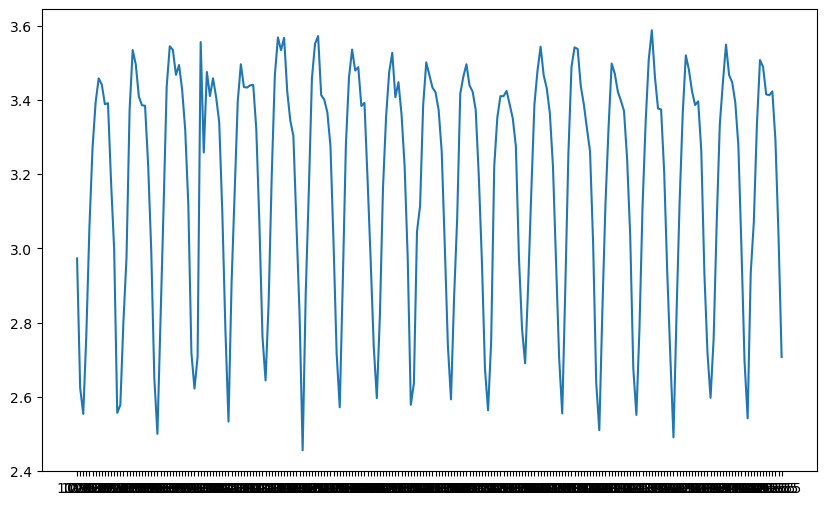

In [5]:
plt.plot(df)
plt.xticks(df.index)
plt.show()

In [7]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['maximumTemp'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

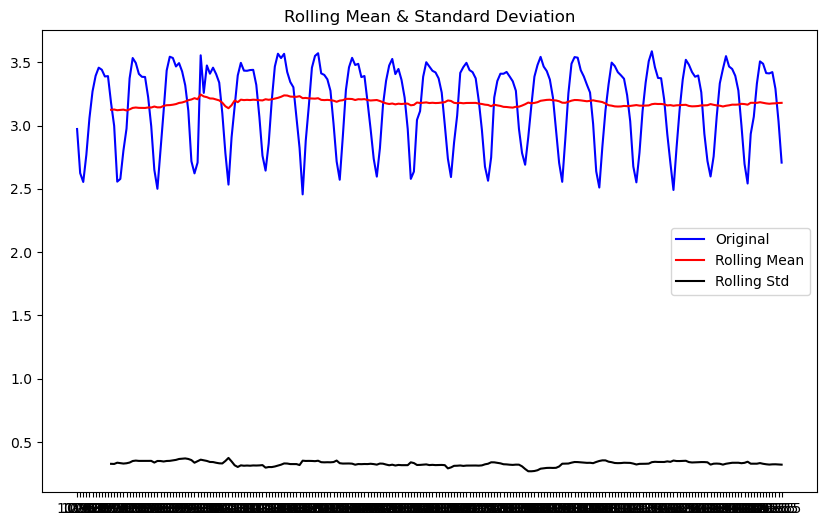

Results of Dickey Fuller Test:
Test Statistic                  -3.160544
p-value                          0.022385
#Lags Used                      13.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


In [8]:
test_stationarity(df)

In [10]:
from statsmodels.tsa.stattools import kpss

# Perform KPSS test
result = kpss(df)

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: 0.019261627599820173
P-value: 0.1


/var/folders/73/1fbt52l13hl2_rtlv49ngykr0000gn/T/ipykernel_27745/1840109679.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df)


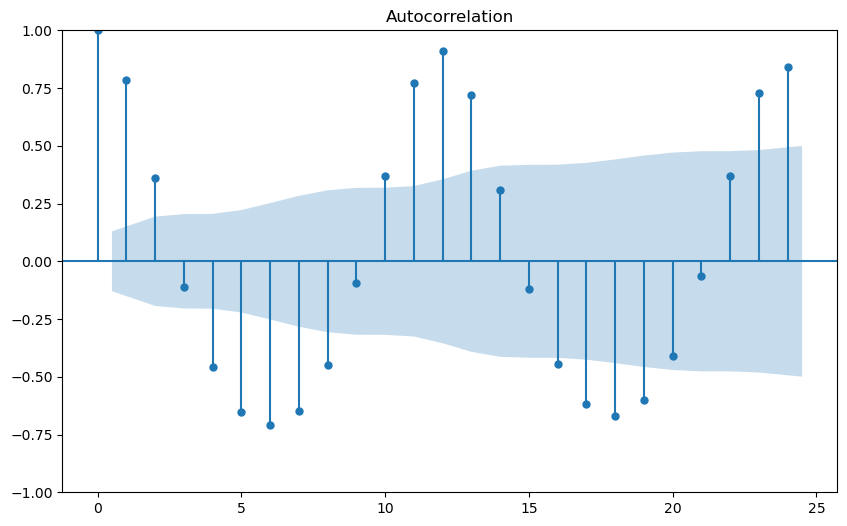

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df)
plt.show()

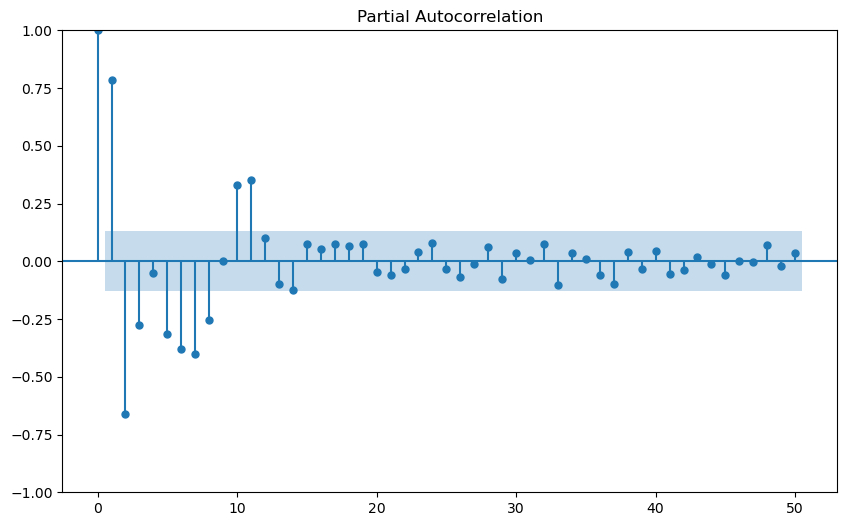

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df, lags=50)
plt.show()

In [18]:
import itertools
import math

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 3)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [12]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))

# Initialize AIC with a large value
best_aic = float("inf")  
best_params = None

# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = sm.tsa.SARIMAX(df, 
                               order=order, 
                               easonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic
        
        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)
        
            if aic < best_aic:
                best_aic = aic
                best_params = params
                
        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be i

(0, 0, 0) (0, 0, 0, 12) 1183.2758248394575
(0, 0, 0) (0, 0, 1, 12) 1183.2758248394575
(0, 0, 0) (1, 0, 0, 12) 1183.2758248394575
(0, 0, 0) (1, 0, 1, 12) 1183.2758248394575
(0, 0, 1) (0, 0, 0, 12) 887.3428257535472
(0, 0, 1) (0, 0, 1, 12) 887.3428257535472
(0, 0, 1) (1, 0, 0, 12) 887.3428257535472
(0, 0, 1) (1, 0, 1, 12) 887.3428257535472
(0, 0, 2) (0, 0, 0, 12) 627.6380684931685
(0, 0, 2) (0, 0, 1, 12) 627.6380684931685
(0, 0, 2) (1, 0, 0, 12) 627.6380684931685
(0, 0, 2) (1, 0, 1, 12) 627.6380684931685
(1, 0, 0) (0, 0, 0, 12) -63.7501310398836
(1, 0, 0) (0, 0, 1, 12) -63.7501310398836
(1, 0, 0) (1, 0, 0, 12) -63.7501310398836
(1, 0, 0) (1, 0, 1, 12) -63.7501310398836
(1, 0, 1) (0, 0, 0, 12) -118.37003888121731


/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be i

(1, 0, 1) (0, 0, 1, 12) -118.37003888121731
(1, 0, 1) (1, 0, 0, 12) -118.37003888121731
(1, 0, 1) (1, 0, 1, 12) -118.37003888121731
(1, 0, 2) (0, 0, 0, 12) -148.59146568645178
(1, 0, 2) (0, 0, 1, 12) -148.59146568645178
(1, 0, 2) (1, 0, 0, 12) -148.59146568645178
(1, 0, 2) (1, 0, 1, 12) -148.59146568645178
(2, 0, 0) (0, 0, 0, 12) -130.13879859317862
(2, 0, 0) (0, 0, 1, 12) -130.13879859317862
(2, 0, 0) (1, 0, 0, 12) -130.13879859317862
(2, 0, 0) (1, 0, 1, 12) -130.13879859317862
(2, 0, 1) (0, 0, 0, 12) -131.27325258085648
(2, 0, 1) (0, 0, 1, 12) -131.27325258085648
(2, 0, 1) (1, 0, 0, 12) -131.27325258085648
(2, 0, 1) (1, 0, 1, 12) -131.27325258085648
(2, 0, 2) (0, 0, 0, 12) -146.77083753088462
(2, 0, 2) (0, 0, 1, 12) -146.77083753088462
(2, 0, 2) (1, 0, 0, 12) -146.77083753088462
(2, 0, 2) (1, 0, 1, 12) -146.77083753088462
Best Parameters: (1, 0, 2, 0, 0, 0, 12)
Best AIC: -148.59146568645178


/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be i

In [19]:
#Best Parameters: (1, 0, 2, 0, 0, 0, 12)
#Best AIC: -148.59146568645178
model = sm.tsa.SARIMAX(df,
                       order=best_params[:3],
                       seasonal_order=best_params[3:])
result = model.fit()

# Show the summary
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.30217D-01    |proj g|=  6.84905D-01

At iterate    5    f= -3.41792D-01    |proj g|=  6.12674D-02

At iterate   10    f= -3.41903D-01    |proj g|=  9.02498D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   9.025D-05  -3.419D-01
  F = -0.34190276350753662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be i

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            maximumTemp   No. Observations:                  229
Model:               SARIMAX(1, 0, 2)   Log Likelihood                  78.296
Date:                Fri, 24 Nov 2023   AIC                           -148.591
Time:                        14:43:10   BIC                           -134.857
Sample:                             0   HQIC                          -143.050
                                - 229                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9946      0.008    119.199      0.000       0.978       1.011
ma.L1          0.5813      0.047     12.284      0.000       0.489       0.674
ma.L2          0.4005      0.071      5.661      0.000       0.262       0.539
sigma2         0.0287      0.002     15.631      0.000       0.025       0.032
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               102.69
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

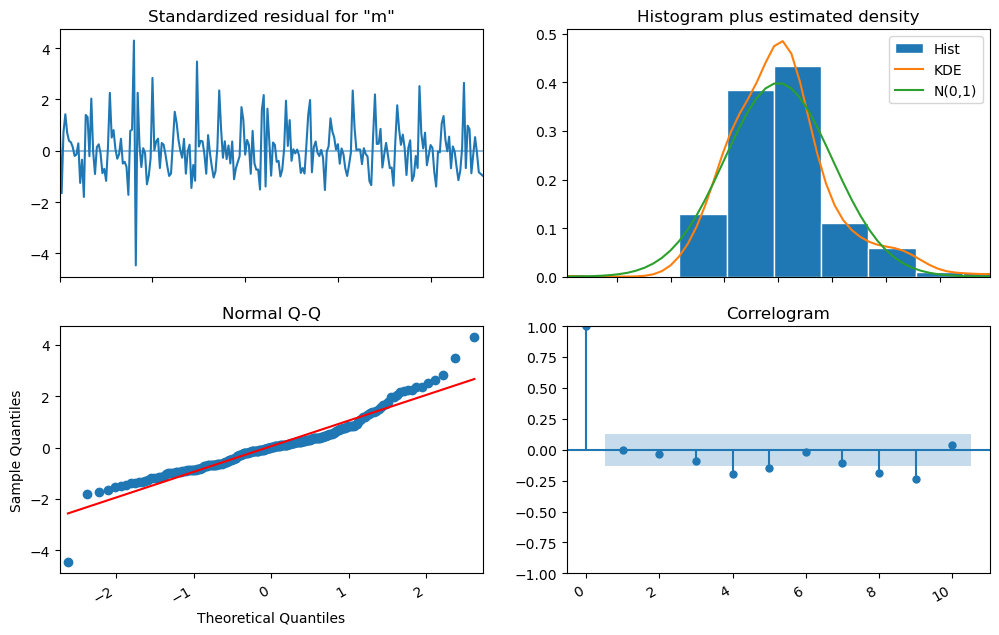

In [20]:
plot=result.plot_diagnostics(figsize=(12,8))
plot.autofmt_xdate()
plt.show()

In [21]:
forecast=result.get_forecast(steps=365)
forecast=forecast.predicted_mean
forecast_cumsum=forecast.cumsum()
values=np.exp(forecast)
values

/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


229    12.634815
230    11.671579
231    11.516408
232    11.364128
233    11.214674
         ...    
589     1.413171
590     1.410511
591     1.407871
592     1.405250
593     1.402649
Name: predicted_mean, Length: 365, dtype: float64

In [27]:
forecast=result.get_forecast(steps=24)
df2017PredictedSARIMA_01=forecast.predicted_mean
df2017PredictedSARIMA_01.to_csv("PLEASE WORK !.csv")

/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/monishramba/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


KeyError: 'lower tmax'

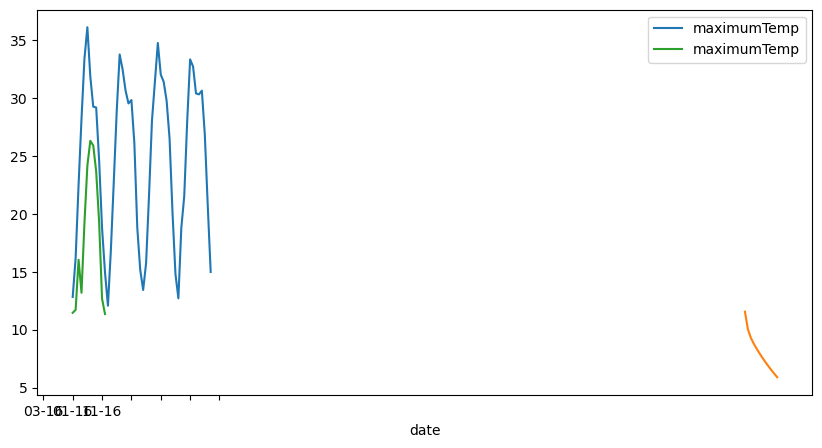

In [54]:
# Get forecast and confidence intervals for two years
forecast = result.get_forecast(steps=12)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot forecast with training data
ax = df[-12*4:].plot(figsize=(10,5))
forecast_values.plot()
df2016.plot(ax=ax)
plt.fill_between(forecast_values.index, 
                 confidence_intervals['lower tmax'], 
                 confidence_intervals['upper tmax'], 
                 color='blue',
                 alpha=0.15)
plt.legend(['Training max temp', 
            'Forecast max temp', 
            'Actual max temp'], 
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.grid(alpha=0.5)
plt.show()

In [57]:
predicted_values

array([11.55696026, 10.03005773,  9.30559743,  8.7957158 ,  8.35476738,
        7.94609166,  7.55991549,  7.19312572,  6.84428412,  6.51239766,
        6.19661397,  5.89614479])

In [56]:
# Predicted values and actual valueszjji/
u
predicted_values = forecast_values.values
actual_values = df2016.values.flatten()

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(predicted_values - actual_values))
print("MAE:", mae)

# Root Mean Squared Error (RMSE)
mse = np.mean((predicted_values - actual_values) ** 2)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((predicted_values - actual_values) / actual_values)) * 100
print("MAPE:", mape)

MAE: 9.920838492196308
RMSE: 11.797139088119476
MAPE: 49.522701982077066
